<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista 6 - LSTM&GRU 
**Nome:** Davy Alves de Souza

**Numero Usp:** 11561247









______________




O objetivo desta lista é fazer com que vocês treinem um modelo de análise de sentimentos utilizando GRU's e LSTM's. Essa lista é semelhante a lista 03 onde aprendemos a usar embeddings e onde você ja recebeu a arquitetura do seu modelo quase pronta. A diferença é que desta vez você ira construir sozinho sua rede e utilizará as camadas que acabamos de aprender: LSTM e GRU.
 
Essa tambêm será a primeira rede recorrente que montaremos, portanto a tokenização será ligeiramente diferente (por exemplo o padding não é mais necessário.)

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
tf.__version__

'2.2.0'

## Importando os dados como um dataframe

Para esta lista nós utilizaremos um recorte de 10 mil linhas do dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [4]:
b2wCorpus = pd.read_csv("../data/b2w-10k.csv")
b2wCorpus.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958,F,RJ,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996,M,SC,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984,M,SP,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985,F,SP,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994,M,MG,NaN,NaN,NaN,NaN,NaN


In [5]:
b2wCorpus["review_text"]

0       Estou contente com a compra entrega rápida o ú...
1       Por apenas R$1994.20,eu consegui comprar esse ...
2       SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3       MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4       A entrega foi no prazo, as americanas estão de...
                              ...                        
9994    Celular muito rápido, com processador e armaze...
9995    achei o produto muito frágil, o material veio ...
9996    Uma porcaria pois ñ recebi ñ recomendo pra nin...
9997    Maquina excelente,super pratica. recomendo.ent...
9998    Agradeço pelo compromisso, obrigado. ,...........
Name: review_text, Length: 9999, dtype: object


## Pré-processamento 
# <font color='blue'>Questão 1 </font>
Copie suas etapas de préprocessamento da lista 03, ou seja, selecione apenas as colunas relevantes ("review_text" e "recommend_to_a_friend"), converta a coluna "review_text" de uma coluna de `str` para uma coluna de `int` e separe os dados em teste e treino.


In [6]:
from sklearn.model_selection import train_test_split

# Selecionando colunas relevantes
processed_data = b2wCorpus[['review_text', 'recommend_to_a_friend']]

# Convertendo str to int [recommend_to_a_friend]
processed_data = processed_data.replace(['Yes', 'No'], [1, 0])

# removendo reviews maiores que 200 caracteres
processed_data = processed_data[processed_data['review_text'].map(len) / 2 < 200]

# separando dados em teste e treino
X = processed_data[['review_text']]
y = processed_data[['recommend_to_a_friend']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

x_train = np.asarray(x_train)
x_test  = np.asarray(x_test)
y_train = np.asarray(y_train)
y_test  = np.asarray(y_test)

In [7]:
# balanceando as classes
from imblearn.under_sampling import RandomUnderSampler

# Class count
count_class_0 = len(y_train[y_train[:,0] == 0])
count_class_1 = len(y_train[y_train[:,0] == 1])
print("classe 0:", count_class_0, "amostras de treinamento")
print("classe 1:", count_class_1, "amostras de treinamento")

# rebalanceando
rus = RandomUnderSampler(random_state=0)
x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)
y_train_resampled = np.reshape(y_train_resampled, (len(y_train_resampled),1))

# Class count
count_0 = len(y_train_resampled[y_train_resampled[:] == 0])
count_1 = len(y_train_resampled[y_train_resampled[:] == 1])
print("classe 0:", count_0, "amostras de treinamento rebalanceadas")
print("classe 1:", count_1, "amostras de treinamento rebalanceadas")

classe 0: 1876 amostras de treinamento
classe 1: 5831 amostras de treinamento
classe 0: 1876 amostras de treinamento rebalanceadas
classe 1: 1876 amostras de treinamento rebalanceadas


## Tokenizando




# <font color='blue'>Questão 2 </font>
Utilizando a camada [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) tokenize os inputs.
Declare a camada e então chame a função `adapt()` no seu conjunto de treino para adequar o seu vocabulário aos reviews. 

Note que o uso de padding não é mais necessario.

In [8]:
# Criando camada de tokenizacao
from tensorflow.keras import layers

max_tokens = 8000
# camada de tokenizacao
vectorize_layer = layers.experimental.preprocessing.TextVectorization(
#     max_tokens = max_tokens,
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
#     ngrams = (1,2), 
    output_mode = "int",
#     output_sequence_length = None, 
#     pad_to_max_tokens = False,
)

vectorize_layer.adapt(x_train)

C:\Users\davys\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\layers\preprocessing\text_vectorization.py:338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(preprocessed_data.to_list())


## LSTM&GRU

Agora vamos juntar a camada do tokenizador a nossa camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) e definir o resto de nosso modelo.

#  <font color='blue'>Questão 3 </font>

a) Defina, compile, treine e avalie seu modelo, utilize camadas  [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/).
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.
 
 
 
b) Como foi a performance desta rede em comparação a da lista 3?




***Resultados Notebook 3:***
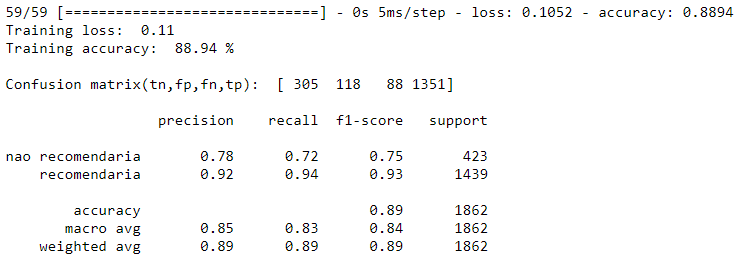



**<font color='red'> Sua resposta aqui </font>**

Podemos notar que a acurácia foi muito próxima entre a rede da lista 3 e a rede LSTM, talvez pela pouca quantidade de dados não pudemos notar um ganho da LSTM em relação a rede anterior

In [8]:
embedding_dim = 600

# Definindo modelo
lstm_model = tf.keras.Sequential([
    # Input, vectorize and embedding layers
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()) + 2, embedding_dim),
    
    # LSTM layers
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilando
lstm_model.compile(optimizer = "rmsprop", loss = "mean_squared_error", metrics = ['accuracy'])
lstm_model.fit(x_train, y_train, epochs = 25)

Epoch 1/25
241/241 [==============================] - 11s 44ms/step - loss: 0.1565 - accuracy: 0.7716
Epoch 2/25
241/241 [==============================] - 11s 44ms/step - loss: 0.1543 - accuracy: 0.7667
Epoch 3/25
241/241 [==============================] - 11s 44ms/step - loss: 0.1222 - accuracy: 0.8486
Epoch 4/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0977 - accuracy: 0.8808
Epoch 5/25
241/241 [==============================] - 10s 43ms/step - loss: 0.0750 - accuracy: 0.9112
Epoch 6/25
241/241 [==============================] - 11s 45ms/step - loss: 0.0625 - accuracy: 0.9244
Epoch 7/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0500 - accuracy: 0.9414
Epoch 8/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0422 - accuracy: 0.9500
Epoch 9/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0354 - accuracy: 0.9578
Epoch 10/25
241/241 [==============================] - 11s 44ms/step - loss: 0.029

In [9]:
# Avaliando modelo LSTM
from sklearn.metrics import classification_report, confusion_matrix

loss, acc = lstm_model.evaluate(x = x_test, y = y_test)
print("Training loss: ", round(loss, 2))
print("Training accuracy: ", round(acc * 100, 2), "%\n")

y_pred = lstm_model.predict(x_test).round()
print("Confusion matrix(tn,fp,fn,tp): ", confusion_matrix(y_test, y_pred).ravel(), "\n")
print(classification_report(y_test, y_pred, target_names=['nao recomendaria', 'recomendaria']))

61/61 [==============================] - 0s 6ms/step - loss: 0.1007 - accuracy: 0.8879
Training loss:  0.1
Training accuracy:  88.79 %

Confusion matrix(tn,fp,fn,tp):  [ 351  118   98 1360] 

                  precision    recall  f1-score   support

nao recomendaria       0.78      0.75      0.76       469
    recomendaria       0.92      0.93      0.93      1458

        accuracy                           0.89      1927
       macro avg       0.85      0.84      0.85      1927
    weighted avg       0.89      0.89      0.89      1927



#  <font color='blue'>Questão 4 </font>

a) Defina, compile, treine e avalie seu modelo, utilize camadas [GRU](https://keras.io/api/layers/recurrent_layers/gru/).
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.
 
 
 
b) Como foi a performance desta rede em comparação a da lista 3?


**<font color='red'> Sua resposta aqui </font>**

Como esperado, a rede GRU perdeu um pouco em qualidade para ganhar em velocidade. Seus resultados também foram muito próximos aos resultados obtidos pelas redes anteriores, alcançando 86% de acurácia. Todavia, não pudemos notar nenhum ganho significativo de velocidade

In [10]:
embedding_dim = 600

# Definindo modelo
gru_model = tf.keras.Sequential([
    # Input, vectorize and embedding layers
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()) + 2, embedding_dim),
    
    # LSTM layers
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.GRU(256),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilando
gru_model.compile(optimizer = "rmsprop", loss = "mean_squared_error", metrics = ['accuracy'])
gru_model.fit(x_train, y_train, epochs = 25)

Epoch 1/25
241/241 [==============================] - 10s 44ms/step - loss: 0.1828 - accuracy: 0.7578
Epoch 2/25
241/241 [==============================] - 10s 43ms/step - loss: 0.1113 - accuracy: 0.8531
Epoch 3/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0635 - accuracy: 0.9190
Epoch 4/25
241/241 [==============================] - 10s 43ms/step - loss: 0.0491 - accuracy: 0.9395
Epoch 5/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0383 - accuracy: 0.9537
Epoch 6/25
241/241 [==============================] - 10s 44ms/step - loss: 0.0308 - accuracy: 0.9630
Epoch 7/25
241/241 [==============================] - 10s 43ms/step - loss: 0.0235 - accuracy: 0.9725
Epoch 8/25
241/241 [==============================] - 10s 44ms/step - loss: 0.0192 - accuracy: 0.9779
Epoch 9/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0159 - accuracy: 0.9808
Epoch 10/25
241/241 [==============================] - 11s 44ms/step - loss: 0.013

In [11]:
# Avaliando modelo GRU
from sklearn.metrics import classification_report, confusion_matrix

loss, acc = gru_model.evaluate(x = x_test, y = y_test)
print("Training loss: ", round(loss, 2))
print("Training accuracy: ", round(acc * 100, 2), "%\n")

y_pred = gru_model.predict(x_test).round()
print("Confusion matrix(tn,fp,fn,tp): ", confusion_matrix(y_test, y_pred).ravel(), "\n")
print(classification_report(y_test, y_pred, target_names=['nao recomendaria', 'recomendaria']))

61/61 [==============================] - 0s 6ms/step - loss: 0.1178 - accuracy: 0.8677
Training loss:  0.12
Training accuracy:  86.77 %

Confusion matrix(tn,fp,fn,tp):  [ 372   97  158 1300] 

                  precision    recall  f1-score   support

nao recomendaria       0.70      0.79      0.74       469
    recomendaria       0.93      0.89      0.91      1458

        accuracy                           0.87      1927
       macro avg       0.82      0.84      0.83      1927
    weighted avg       0.87      0.87      0.87      1927



## Redes Bi-direcionais
#  <font color='blue'>Questão 5 </font>

a) Defina, compile, treine e avalie um novo modelo que utilize contexto em ambas as direções usando a camada [`Bidirectional()`](https://keras.io/api/layers/recurrent_layers/bidirectional/), seja com camadas GRU ou LSTM.


b) Como foi sua performance em relação as questões anteriores com contexto unidirecional?

**<font color='red'> Sua resposta aqui </font>**

Por fim as redes bidirecionais também obtiveram 88% de acurácia, assim como a a rede especificada na lista 3.

In [12]:
embedding_dim = 600

# Definindo modelo
bidirectional_model = tf.keras.Sequential([
    # Input, vectorize and embedding layers
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()) + 2, embedding_dim),
    
    # LSTM layers
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilando
bidirectional_model.compile(optimizer = "rmsprop", loss = "mean_squared_error", metrics = ['accuracy'])
bidirectional_model.fit(x_train, y_train, epochs = 25)

Epoch 1/25
241/241 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.86 - 11s 44ms/step - loss: 0.0974 - accuracy: 0.8692
Epoch 2/25
241/241 [==============================] - 11s 45ms/step - loss: 0.0647 - accuracy: 0.9176
Epoch 3/25
241/241 [==============================] - 11s 45ms/step - loss: 0.0488 - accuracy: 0.9378
Epoch 4/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0404 - accuracy: 0.9507
Epoch 5/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0313 - accuracy: 0.9629
Epoch 6/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0265 - accuracy: 0.9681
Epoch 7/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0225 - accuracy: 0.9735
Epoch 8/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0173 - accuracy: 0.9803
Epoch 9/25
241/241 [==============================] - 11s 44ms/step - loss: 0.0132 - accuracy: 0.9848
Epoch 10/25
241/241 [===================

In [13]:
# Avaliando modelo bidirecional
from sklearn.metrics import classification_report, confusion_matrix

loss, acc = bidirectional_model.evaluate(x = x_test, y = y_test)
print("Training loss: ", round(loss, 2))
print("Training accuracy: ", round(acc * 100, 2), "%\n")

y_pred = bidirectional_model.predict(x_test).round()
print("Confusion matrix(tn,fp,fn,tp): ", confusion_matrix(y_test, y_pred).ravel(), "\n")
print(classification_report(y_test, y_pred, target_names=['nao recomendaria', 'recomendaria']))

61/61 [==============================] - 1s 9ms/step - loss: 0.0998 - accuracy: 0.8874
Training loss:  0.1
Training accuracy:  88.74 %

Confusion matrix(tn,fp,fn,tp):  [ 363  106  111 1347] 

                  precision    recall  f1-score   support

nao recomendaria       0.77      0.77      0.77       469
    recomendaria       0.93      0.92      0.93      1458

        accuracy                           0.89      1927
       macro avg       0.85      0.85      0.85      1927
    weighted avg       0.89      0.89      0.89      1927



***Utilizando um dataset balanceado***

Por fim, um último teste realizado foi a execução da rede LSTM fazendo um downsampling nos dataset original para que ele fosse balanceado. Os resultados ainda se mantiveram entre 86% ~ 88%

In [9]:
# LSTM (dados rebalanceados)
embedding_dim = 600

# Definindo modelo
lstm_model_resampled = tf.keras.Sequential([
    # Input, vectorize and embedding layers
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()) + 2, embedding_dim),
    
    # LSTM layers
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilando
lstm_model_resampled.compile(optimizer = "rmsprop", loss = "mean_squared_error", metrics = ['accuracy'])
lstm_model_resampled.fit(x_train_resampled, y_train_resampled, epochs = 40)

Epoch 1/40
118/118 [==============================] - 28s 234ms/step - loss: 0.2418 - accuracy: 0.5656
Epoch 2/40
118/118 [==============================] - 28s 233ms/step - loss: 0.2291 - accuracy: 0.6229
Epoch 3/40
118/118 [==============================] - 28s 234ms/step - loss: 0.1582 - accuracy: 0.7953
Epoch 4/40
118/118 [==============================] - 28s 236ms/step - loss: 0.1625 - accuracy: 0.7745
Epoch 5/40
118/118 [==============================] - 27s 232ms/step - loss: 0.1821 - accuracy: 0.7401
Epoch 6/40
118/118 [==============================] - 27s 230ms/step - loss: 0.1410 - accuracy: 0.8281
Epoch 7/40
118/118 [==============================] - 27s 228ms/step - loss: 0.1454 - accuracy: 0.7948
Epoch 8/40
118/118 [==============================] - 27s 232ms/step - loss: 0.0938 - accuracy: 0.8777
Epoch 9/40
118/118 [==============================] - 27s 232ms/step - loss: 0.0774 - accuracy: 0.9049
Epoch 10/40
118/118 [==============================] - 28s 236ms/step - l

In [11]:
# Avaliando modelo LSTM (base rebalanceada)
from sklearn.metrics import classification_report, confusion_matrix

loss, acc = lstm_model_resampled.evaluate(x = x_test, y = y_test)
print("Training loss: ", round(loss, 2))
print("Training accuracy: ", round(acc * 100, 2), "%\n")

y_pred = lstm_model_resampled.predict(x_test).round()
print("Confusion matrix(tn,fp,fn,tp): ", confusion_matrix(y_test, y_pred).ravel(), "\n")
print(classification_report(y_test, y_pred, target_names=['nao recomendaria', 'recomendaria']))

61/61 [==============================] - 4s 67ms/step - loss: 0.1343 - accuracy: 0.8609
Training loss:  0.13
Training accuracy:  86.09 %

Confusion matrix(tn,fp,fn,tp):  [ 377   86  182 1282] 

                  precision    recall  f1-score   support

nao recomendaria       0.67      0.81      0.74       463
    recomendaria       0.94      0.88      0.91      1464

        accuracy                           0.86      1927
       macro avg       0.81      0.84      0.82      1927
    weighted avg       0.87      0.86      0.87      1927

